In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from bs4 import BeautifulSoup
import re
import requests
import unidecode

pd.set_option('display.max_columns', None)

pd.options.display.max_columns=999

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
MLS2021_PlayerGames = pd.read_csv('../Data/FBRef_MLS_PlayerGames.csv')
MLS2021_PlayerGames = MLS2021_PlayerGames[(MLS2021_PlayerGames['Date'] > 20210101) & (MLS2021_PlayerGames['Date'] <= 20211123)]
MLS2021_PlayerGames

,Date,Team,Opp,HorA,Manager,Captain,Referee,Player,#,Nation,Pos,Age,Min,Sub,Replace,Summary_Performance_Gls,Summary_Performance_Ast,Summary_Performance_PK,Summary_Performance_PKatt,Summary_Performance_Sh,Summary_Performance_SoT,Summary_Performance_CrdY,Summary_Performance_CrdR,Summary_Performance_Touches,Summary_Performance_Press,Summary_Performance_Tkl,Summary_Performance_Int,Summary_Performance_Blocks,Summary_Expected_xG,Summary_Expected_npxG,Summary_Expected_xA,Summary_SCA_SCA,Summary_SCA_GCA,Summary_Passes_Cmp,Summary_Passes_Att,Summary_Passes_Cmp%,Summary_Passes_Prog,Summary_Carries_Carries,Summary_Carries_Prog,Summary_Dribbles_Succ,Summary_Dribbles_Att,Passing_Total_Cmp,Passing_Total_Att,Passing_Total_Cmp%,Passing_Total_TotDist,Passing_Total_ProgDist,Passing_Short_Cmp,Passing_Short_Att,Passing_Short_Cmp%,Passing_Medium_Cmp,Passing_Medium_Att,Passing_Medium_Cmp%,Passing_Long_Cmp,Passing_Long_Att,Passing_Long_Cmp%,Passing__Ast,Passing__xA,Passing__KP,Passing__1/3,Passing__PPA,Passing__CrsPA,Passing__Prog,Pass Types_Pass Types_Live,Pass Types_Pass Types_Dead,Pass Types_Pass Types_FK,Pass Types_Pass Types_TB,Pass Types_Pass Types_Press,Pass Types_Pass Types_Sw,Pass Types_Pass Types_Crs,Pass Types_Pass Types_CK,Pass Types_Corner Kicks_In,Pass Types_Corner Kicks_Out,Pass Types_Corner Kicks_Str,Pass Types_Height_Ground,Pass Types_Height_Low,Pass Types_Height_High,Pass Types_Body Parts_Left,Pass Types_Body Parts_Right,Pass Types_Body Parts_Head,Pass Types_Body Parts_TI,Pass Types_Body Parts_Other,Pass Types_Outcomes_Cmp,Pass Types_Outcomes_Off,Pass Types_Outcomes_Out,Pass Types_Outcomes_Int,Pass Types_Outcomes_Blocks,Defensive Actions_Tackles_Tkl,Defensive Actions_Tackles_TklW,Defensive Actions_Tackles_Def 3rd,Defensive Actions_Tackles_Mid 3rd,Defensive Actions_Tackles_Att 3rd,Defensive Actions_Vs Dribbles_Tkl,Defensive Actions_Vs Dribbles_Att,Defensive Actions_Vs Dribbles_Tkl%,Defensive Actions_Vs Dribbles_Past,Defensive Actions_Pressures_Press,Defensive Actions_Pressures_Succ,Defensive Actions_Pressures_%,Defensive Actions_Pressures_Def 3rd,Defensive Actions_Pressures_Mid 3rd,Defensive Actions_Pressures_Att 3rd,Defensive Actions_Blocks_Blocks,Defensive Actions_Blocks_Sh,Defensive Actions_Blocks_ShSv,Defensive Actions_Blocks_Pass,Defensive Actions__Int,Defensive Actions__Tkl+Int,Defensive Actions__Clr,Defensive Actions__Err,Possession_Touches_Touches,Possession_Touches_Def Pen,Possession_Touches_Def 3rd,Possession_Touches_Med 3rd,Possession_Touches_Att 3rd,Possession_Touches_Att Pen,Possession_Touches_Live,Possession_Dribbles_Succ,Possession_Dribbles_Att,Possession_Dribbles_Succ%,Possession_Dribbles_#Pl,Possession_Dribbles_Megs,Possession_Carries_Carries,Possession_Carries_TotDist,Possession_Carries_PrgDist,Possession_Carries_Prog,Possession_Carries_1/3,Possession_Carries_CPA,Possession_Carries_Mis,Possession_Carries_Dis,Possession_Receiving_Targ,Possession_Receiving_Rec,Possession_Receiving_Rec%,Possession_Receiving_Prog,Miscellaneous_Performance_CrdY,Miscellaneous_Performance_CrdR,Miscellaneous_Performance_2CrdY,Miscellaneous_Performance_Fls,Miscellaneous_Performance_Fld,Miscellaneous_Performance_Off,Miscellaneous_Performance_Crs,Miscellaneous_Performance_Int,Miscellaneous_Performance_TklW,Miscellaneous_Performance_PKwon,Miscellaneous_Performance_PKcon,Miscellaneous_Performance_OG,Miscellaneous_Performance_Recov,Miscellaneous_Aerial Duels_Won,Miscellaneous_Aerial Duels_Lost,Miscellaneous_Aerial Duels_Won%
0,20210416,Houston Dynamo,San Jose Earthquakes,H,Tab Ramos,Boniek García,Armando Villarreal,Maximiliano Urruti,37,ARG,FW,30.147222,86,0,Christian Ramirez,1,0,0,0,4,3,0,0,34.0,31,0,0,2,0.5,0.5,0.2,4,0,19,24,79.2,2,24,1,0,0,19,24,79.2,268,38,12,14,85.7,6,6,100.0,0,2,0.0,0,0.2,2,1,2,0,2,22,2,0,1,7,1,0,0,0,0,0,22,1,1,1,23,0,0,0,19,0,0,1,1,0,0,0,0,0,0,2,0.0,2,31,11,35.5,1,11,19,2,0,0,2,0,0,0,0,34,0,0,12,23,4,32,0,0,NaN,0,0,24,85,17,1,1,0,3,0,39,24,61.5,5,0,0,0,0,1,2,0,0,0,0.0,0.0,0,6,0,1,0.0
1,20210416,Houston Dynamo,San Jose Ear

In [3]:
# We'll be analyzing Philly as a team, so group players into teams, but keep games separate
MLS2021_TeamGames = MLS2021_PlayerGames.groupby(['Date', 'Team', 'Opp']).sum().reset_index()
MLS2021_TeamGames

,Date,Team,Opp,#,Age,Min,Sub,Summary_Performance_Gls,Summary_Performance_Ast,Summary_Performance_PK,Summary_Performance_PKatt,Summary_Performance_Sh,Summary_Performance_SoT,Summary_Performance_CrdY,Summary_Performance_CrdR,Summary_Performance_Touches,Summary_Performance_Press,Summary_Performance_Tkl,Summary_Performance_Int,Summary_Performance_Blocks,Summary_Expected_xG,Summary_Expected_npxG,Summary_Expected_xA,Summary_SCA_SCA,Summary_SCA_GCA,Summary_Passes_Cmp,Summary_Passes_Att,Summary_Passes_Cmp%,Summary_Passes_Prog,Summary_Carries_Carries,Summary_Carries_Prog,Summary_Dribbles_Succ,Summary_Dribbles_Att,Passing_Total_Cmp,Passing_Total_Att,Passing_Total_Cmp%,Passing_Total_TotDist,Passing_Total_ProgDist,Passing_Short_Cmp,Passing_Short_Att,Passing_Short_Cmp%,Passing_Medium_Cmp,Passing_Medium_Att,Passing_Medium_Cmp%,Passing_Long_Cmp,Passing_Long_Att,Passing_Long_Cmp%,Passing__Ast,Passing__xA,Passing__KP,Passing__1/3,Passing__PPA,Passing__CrsPA,Passing__Prog,Pass Types_Pass Types_Live,Pass Types_Pass Types_Dead,Pass Types_Pass Types_FK,Pass Types_Pass Types_TB,Pass Types_Pass Types_Press,Pass Types_Pass Types_Sw,Pass Types_Pass Types_Crs,Pass Types_Pass Types_CK,Pass Types_Corner Kicks_In,Pass Types_Corner Kicks_Out,Pass Types_Corner Kicks_Str,Pass Types_Height_Ground,Pass Types_Height_Low,Pass Types_Height_High,Pass Types_Body Parts_Left,Pass Types_Body Parts_Right,Pass Types_Body Parts_Head,Pass Types_Body Parts_TI,Pass Types_Body Parts_Other,Pass Types_Outcomes_Cmp,Pass Types_Outcomes_Off,Pass Types_Outcomes_Out,Pass Types_Outcomes_Int,Pass Types_Outcomes_Blocks,Defensive Actions_Tackles_Tkl,Defensive Actions_Tackles_TklW,Defensive Actions_Tackles_Def 3rd,Defensive Actions_Tackles_Mid 3rd,Defensive Actions_Tackles_Att 3rd,Defensive Actions_Vs Dribbles_Tkl,Defensive Actions_Vs Dribbles_Att,Defensive Actions_Vs Dribbles_Tkl%,Defensive Actions_Vs Dribbles_Past,Defensive Actions_Pressures_Press,Defensive Actions_Pressures_Succ,Defensive Actions_Pressures_%,Defensive Actions_Pressures_Def 3rd,Defensive Actions_Pressures_Mid 3rd,Defensive Actions_Pressures_Att 3rd,Defensive Actions_Blocks_Blocks,Defensive Actions_Blocks_Sh,Defensive Actions_Blocks_ShSv,Defensive Actions_Blocks_Pass,Defensive Actions__Int,Defensive Actions__Tkl+Int,Defensive Actions__Clr,Defensive Actions__Err,Possession_Touches_Touches,Possession_Touches_Def Pen,Possession_Touches_Def 3rd,Possession_Touches_Med 3rd,Possession_Touches_Att 3rd,Possession_Touches_Att Pen,Possession_Touches_Live,Possession_Dribbles_Succ,Possession_Dribbles_Att,Possession_Dribbles_Succ%,Possession_Dribbles_#Pl,Possession_Dribbles_Megs,Possession_Carries_Carries,Possession_Carries_TotDist,Possession_Carries_PrgDist,Possession_Carries_Prog,Possession_Carries_1/3,Possession_Carries_CPA,Possession_Carries_Mis,Possession_Carries_Dis,Possession_Receiving_Targ,Possession_Receiving_Rec,Possession_Receiving_Rec%,Possession_Receiving_Prog,Miscellaneous_Performance_CrdY,Miscellaneous_Performance_CrdR,Miscellaneous_Performance_2CrdY,Miscellaneous_Performance_Fls,Miscellaneous_Performance_Fld,Miscellaneous_Performance_Off,Miscellaneous_Performance_Crs,Miscellaneous_Performance_Int,Miscellaneous_Performance_TklW,Miscellaneous_Performance_PKwon,Miscellaneous_Performance_PKcon,Miscellaneous_Performance_OG,Miscellaneous_Performance_Recov,Miscellaneous_Aerial Duels_Won,Miscellaneous_Aerial Duels_Lost,Miscellaneous_Aerial Duels_Won%
0,20210416,Houston Dynamo,San Jose Earthquakes,215,427.677778,990,4,2,2,0,0,17,6,3,0,447.0,167,17,9,16,1.4,1.4,1.2,30,4,234,336,997.1,33,222,31,5,11,234,336,997.1,4321,1996,118,141,1137.6,85,106,983.7,29,77,553.3,2,1.2,14,27,5,2,33,279,57,17,1,52,9,12,5,2,3,0,217,41,78,88,188,20,27,3,234,3,11,13,9,17,9,8,7,2,7,10,600.0,3,167,54,406.6,35,72,60,16,1,0,15,9,26,12,0,447,31,117,189,163,24,392,5,11,266.7,6,0,222,1299,687,31,8,6,13,6,296,234,1173.8,33,3,0,0,15,16,4,12,9,9,0.0,0.0,0,88,11,12,450.0
1,20210416,Minnesota United,Seattle Sounders FC,382,431.080556,990,4,0,0,0,0,17,4,2,0,594.

In [4]:
# Again, need to create Middle and Attacking 3rd combined stat
MLS2021_PlayerGames['Possession_Touches_Mid+Att 3rd'] = MLS2021_PlayerGames['Possession_Touches_Med 3rd'] + MLS2021_PlayerGames['Possession_Touches_Att 3rd']

In [5]:
# Check out which players have a stat that stands out (>98th percentile)
# From the last Nashville vs Philly game
cutoff = 95
print('Nashville SC')

NSH_percs = MLS2021_PlayerGames[(MLS2021_PlayerGames['Team'] == 'Nashville SC') & (MLS2021_PlayerGames['Date'] == 20211023)]
NSH_percs[list(NSH_percs.columns[15:])] = NSH_percs[list(NSH_percs.columns[15:])].astype(float)
for p in NSH_percs.index:
    for stat_col in NSH_percs.columns[15:]:
        if (~pd.isna(NSH_percs[stat_col][p])):
            #perc = stats.percentileofscore(MLS2021_PlayerGames[(MLS2021_PlayerGames['Pos'] == NSH_percs['Pos'][p]) & (~pd.isna(MLS2021_PlayerGames[stat_col]))][stat_col], NSH_percs[stat_col][p], 'mean')
            perc = stats.percentileofscore(MLS2021_PlayerGames[(MLS2021_PlayerGames['Opp'] == 'Philadelphia Union') & (~pd.isna(MLS2021_PlayerGames[stat_col]))][stat_col], NSH_percs[stat_col][p], 'mean')
            NSH_percs[stat_col][p] = perc
            if (perc > cutoff):
                print(NSH_percs['Player'][p], stat_col, perc)

print("\Philadelphia Union")
PHI_percs = MLS2021_PlayerGames[(MLS2021_PlayerGames['Team'] == 'Philadelphia Union') & (MLS2021_PlayerGames['Date'] == 20211023)]
PHI_percs[list(PHI_percs.columns[15:])] = PHI_percs[list(PHI_percs.columns[15:])].astype(float)
for p in PHI_percs.index:
    for stat_col in PHI_percs.columns[15:]:
        if (~pd.isna(PHI_percs[stat_col][p])):
            #perc = stats.percentileofscore(MLS2021_PlayerGames[(MLS2021_PlayerGames['Pos'] == PHI_percs['Pos'][p]) & (~pd.isna(MLS2021_PlayerGames[stat_col]))][stat_col], PHI_percs[stat_col][p], 'mean')
            perc = stats.percentileofscore(MLS2021_PlayerGames[(MLS2021_PlayerGames['Opp'] == 'Nashville SC') & (~pd.isna(MLS2021_PlayerGames[stat_col]))][stat_col], PHI_percs[stat_col][p], 'mean')
            PHI_percs[stat_col][p] = perc
            if (perc > cutoff):
                print(PHI_percs['Player'][p], stat_col, perc)

Nashville SC
C.J. Sapong Defensive Actions_Tackles_Att 3rd 99.25093632958801
C.J. Sapong Possession_Touches_Att Pen 96.25468164794007
C.J. Sapong Miscellaneous_Performance_Off 96.16104868913857
Arnaud Ake Possession_Carries_Dis 98.12734082397003
Arnaud Ake Miscellaneous_Performance_Off 96.16104868913857
Abu Danladi Passing__CrsPA 98.31460674157303
Randall Leal Pass Types_Pass Types_Sw 96.72284644194757
Randall Leal Pass Types_Pass Types_Crs 96.34831460674157
Randall Leal Pass Types_Pass Types_CK 95.59925093632958
Randall Leal Pass Types_Corner Kicks_Out 98.31460674157303
Randall Leal Pass Types_Body Parts_Right 95.13108614232209
Randall Leal Possession_Dribbles_Megs 97.84644194756554
Randall Leal Possession_Carries_Dis 95.59925093632958
Randall Leal Miscellaneous_Performance_Fls 98.40823970037454
Randall Leal Miscellaneous_Performance_Crs 96.34831460674157
Aníbal Godoy Summary_Performance_Tkl 98.68913857677903
Aníbal Godoy Summary_Performance_Int 96.25468164794007
Aníbal Godoy Summary_

Alejandro Bedoya Defensive Actions_Tackles_Tkl 96.82080924855492
Alejandro Bedoya Defensive Actions_Tackles_TklW 97.59152215799615
Alejandro Bedoya Defensive Actions_Tackles_Mid 3rd 98.36223506743738
Alejandro Bedoya Miscellaneous_Performance_Off 95.95375722543352
Alejandro Bedoya Miscellaneous_Performance_TklW 97.59152215799615
José Andrés Martínez Summary_Passes_Prog 95.95375722543352
José Andrés Martínez Passing_Long_Cmp 95.27938342967245
José Andrés Martínez Passing__Prog 95.95375722543352
José Andrés Martínez Pass Types_Pass Types_Live 95.27938342967245
José Andrés Martínez Pass Types_Pass Types_Sw 97.20616570327553
José Andrés Martínez Pass Types_Height_High 96.6281310211946
José Andrés Martínez Pass Types_Body Parts_Right 96.6281310211946
José Andrés Martínez Pass Types_Body Parts_Head 99.61464354527938
José Andrés Martínez Possession_Touches_Touches 95.08670520231213
José Andrés Martínez Possession_Touches_Live 96.14643545279384
José Andrés Martínez Miscellaneous_Performance_Re

In [6]:
# Create G-xG to check out if Jakob Glesnes is outperforming xG with those rockets
MLS2021_PlayerGames['G-xG'] = MLS2021_PlayerGames['Summary_Performance_Gls'] - MLS2021_PlayerGames['Summary_Expected_xG']
MLS2021_PlayerGames

,Date,Team,Opp,HorA,Manager,Captain,Referee,Player,#,Nation,Pos,Age,Min,Sub,Replace,Summary_Performance_Gls,Summary_Performance_Ast,Summary_Performance_PK,Summary_Performance_PKatt,Summary_Performance_Sh,Summary_Performance_SoT,Summary_Performance_CrdY,Summary_Performance_CrdR,Summary_Performance_Touches,Summary_Performance_Press,Summary_Performance_Tkl,Summary_Performance_Int,Summary_Performance_Blocks,Summary_Expected_xG,Summary_Expected_npxG,Summary_Expected_xA,Summary_SCA_SCA,Summary_SCA_GCA,Summary_Passes_Cmp,Summary_Passes_Att,Summary_Passes_Cmp%,Summary_Passes_Prog,Summary_Carries_Carries,Summary_Carries_Prog,Summary_Dribbles_Succ,Summary_Dribbles_Att,Passing_Total_Cmp,Passing_Total_Att,Passing_Total_Cmp%,Passing_Total_TotDist,Passing_Total_ProgDist,Passing_Short_Cmp,Passing_Short_Att,Passing_Short_Cmp%,Passing_Medium_Cmp,Passing_Medium_Att,Passing_Medium_Cmp%,Passing_Long_Cmp,Passing_Long_Att,Passing_Long_Cmp%,Passing__Ast,Passing__xA,Passing__KP,Passing__1/3,Passing__PPA,Passing__CrsPA,Passing__Prog,Pass Types_Pass Types_Live,Pass Types_Pass Types_Dead,Pass Types_Pass Types_FK,Pass Types_Pass Types_TB,Pass Types_Pass Types_Press,Pass Types_Pass Types_Sw,Pass Types_Pass Types_Crs,Pass Types_Pass Types_CK,Pass Types_Corner Kicks_In,Pass Types_Corner Kicks_Out,Pass Types_Corner Kicks_Str,Pass Types_Height_Ground,Pass Types_Height_Low,Pass Types_Height_High,Pass Types_Body Parts_Left,Pass Types_Body Parts_Right,Pass Types_Body Parts_Head,Pass Types_Body Parts_TI,Pass Types_Body Parts_Other,Pass Types_Outcomes_Cmp,Pass Types_Outcomes_Off,Pass Types_Outcomes_Out,Pass Types_Outcomes_Int,Pass Types_Outcomes_Blocks,Defensive Actions_Tackles_Tkl,Defensive Actions_Tackles_TklW,Defensive Actions_Tackles_Def 3rd,Defensive Actions_Tackles_Mid 3rd,Defensive Actions_Tackles_Att 3rd,Defensive Actions_Vs Dribbles_Tkl,Defensive Actions_Vs Dribbles_Att,Defensive Actions_Vs Dribbles_Tkl%,Defensive Actions_Vs Dribbles_Past,Defensive Actions_Pressures_Press,Defensive Actions_Pressures_Succ,Defensive Actions_Pressures_%,Defensive Actions_Pressures_Def 3rd,Defensive Actions_Pressures_Mid 3rd,Defensive Actions_Pressures_Att 3rd,Defensive Actions_Blocks_Blocks,Defensive Actions_Blocks_Sh,Defensive Actions_Blocks_ShSv,Defensive Actions_Blocks_Pass,Defensive Actions__Int,Defensive Actions__Tkl+Int,Defensive Actions__Clr,Defensive Actions__Err,Possession_Touches_Touches,Possession_Touches_Def Pen,Possession_Touches_Def 3rd,Possession_Touches_Med 3rd,Possession_Touches_Att 3rd,Possession_Touches_Att Pen,Possession_Touches_Live,Possession_Dribbles_Succ,Possession_Dribbles_Att,Possession_Dribbles_Succ%,Possession_Dribbles_#Pl,Possession_Dribbles_Megs,Possession_Carries_Carries,Possession_Carries_TotDist,Possession_Carries_PrgDist,Possession_Carries_Prog,Possession_Carries_1/3,Possession_Carries_CPA,Possession_Carries_Mis,Possession_Carries_Dis,Possession_Receiving_Targ,Possession_Receiving_Rec,Possession_Receiving_Rec%,Possession_Receiving_Prog,Miscellaneous_Performance_CrdY,Miscellaneous_Performance_CrdR,Miscellaneous_Performance_2CrdY,Miscellaneous_Performance_Fls,Miscellaneous_Performance_Fld,Miscellaneous_Performance_Off,Miscellaneous_Performance_Crs,Miscellaneous_Performance_Int,Miscellaneous_Performance_TklW,Miscellaneous_Performance_PKwon,Miscellaneous_Performance_PKcon,Miscellaneous_Performance_OG,Miscellaneous_Performance_Recov,Miscellaneous_Aerial Duels_Won,Miscellaneous_Aerial Duels_Lost,Miscellaneous_Aerial Duels_Won%,Possession_Touches_Mid+Att 3rd,G-xG
0,20210416,Houston Dynamo,San Jose Earthquakes,H,Tab Ramos,Boniek García,Armando Villarreal,Maximiliano Urruti,37,ARG,FW,30.147222,86,0,Christian Ramirez,1,0,0,0,4,3,0,0,34.0,31,0,0,2,0.5,0.5,0.2,4,0,19,24,79.2,2,24,1,0,0,19,24,79.2,268,38,12,14,85.7,6,6,100.0,0,2,0.0,0,0.2,2,1,2,0,2,22,2,0,1,7,1,0,0,0,0,0,22,1,1,1,23,0,0,0,19,0,0,1,1,0,0,0,0,0,0,2,0.0,2,31,11,35.5,1,11,19,2,0,0,2,0,0,0,0,34,0,0,12,23,4,32,0,0,NaN,0,0,24,85,17,1,1,0,3,0,39,24,61.5,5,0,0,0,0,1,2,0,0,0,0.0,0.0,0,6,0,1,0.0,35

In [9]:
# We lose the Pos column when we group, so let's make sure we get only CB player-games
cb_idx = []
for i in MLS2021_PlayerGames.index:
    if ('CB' in MLS2021_PlayerGames['Pos'][i]): cb_idx.append(i)
CBs = MLS2021_PlayerGames.loc[cb_idx]
CBs = CBs.groupby('Player').sum().sort_values(by='G-xG', ascending=False).reset_index()[['Player', 'G-xG']]
CBs

,Player,G-xG
0,Jakob Glesnes,2.7
1,Robin Jansson,2.1
2,Mamadou Fall,2.0
3,Rudy Camacho,1.9
4,Omar Gonzalez,1.7
...,...,...
209,Tim Parker,-1.2
210,Tanner Beason,-1.3
211,Chris Wondolowski,-1.3
212,David Romney,-1.4


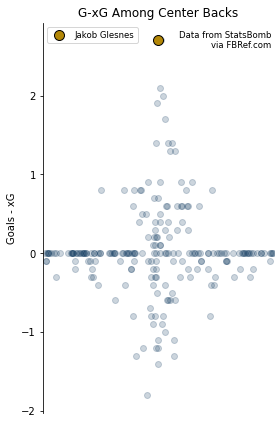

In [11]:
player = 'Jakob Glesnes'
team = 'Philadelphia Union'
#stat = 'Tackles and Interceptions'
#stat_col = 'Defensive Actions__Tkl+Int'
stat = 'Goals - xG'
stat_col = 'G-xG'
bound=10

if (team == 'Orlando City'):
    dotcolor_back='#623193'
    dotcolor_target='#FEE293'
elif (team == 'Nashville SC'):
    dotcolor_back='#190F44'
    dotcolor_target='#ECE838'
elif (team == 'Philadelphia Union'):
    dotcolor_back='#002D55'
    dotcolor_target='#B38707'

# MAKE DataFrames FOR PLOT
for_plot = CBs.copy()

for_plot['x'] = for_plot[stat_col].apply(lambda x: np.random.uniform(max(-1*(for_plot[stat_col] == x).sum()/bound,-1),min((for_plot[stat_col] == x).sum()/bound,1)))

player_idx = for_plot[for_plot['Player'] == player].index[0]

fig, ax = plt.subplots(1, 1, figsize=(4,6))
ax.scatter(x=for_plot['x'], y=for_plot[stat_col], color=dotcolor_back, alpha=0.2)
player_dot = ax.scatter(x=[0], y=for_plot[stat_col][player_idx], color=dotcolor_target, edgecolor='black', s=100,
                           label=f"{player}")
#ax.set_ylim(ax.get_ylim())
ax.set_xlim(-1, 1)
ax.set_xticks([])
ax.set_title("G-xG Among Center Backs")
ax.set_ylabel(stat)
ax.text(x=0.99, y=0.98, s="Data from StatsBomb\nvia FBRef.com", va='top', ha='right',
           transform=ax.transAxes, fontsize=8.5)
ax.legend(handles=[player_dot], fontsize=8.5, loc='upper left')
#ax.text(x=max(just_player[just_player[stat_col] == for_plot[stat_col][player_idx]]['x'].max()*1.25, (ax.get_xlim()[1]-ax.get_xlim()[0])*0.04), y=for_plot[stat_col][player_idx],
#           s=f"Percentile: {stats.percentileofscore(just_player[stat_col], for_plot[stat_col][player_idx], 'mean'):.1f}%",
#           fontsize=9, clip_on=True)
#for t in legend.get_texts():
#    t.set_ha('right')


ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f"PHI_Report_Plots/CB_G-xG_Swarmplot.png", dpi=200)

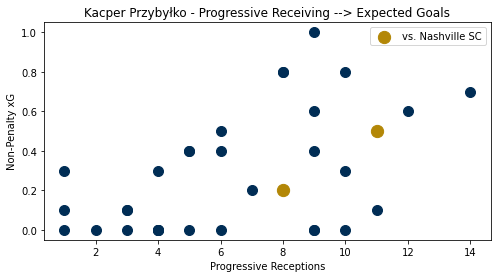

In [12]:
# Probably intuitive that more receptions near the goal leads to more goals, but an important point
# after we let Orlando hang out in our 18
plt.figure(figsize=(8,4))
for_plot = MLS2021_PlayerGames[MLS2021_PlayerGames['Player'] == 'Kacper Przybyłko']
plt.scatter(for_plot['Possession_Receiving_Prog'], for_plot['Summary_Expected_npxG'], color='#002D55', s=100)
plt.scatter(for_plot[for_plot['Opp'] == 'Nashville SC']['Possession_Receiving_Prog'], for_plot[for_plot['Opp'] == 'Nashville SC']['Summary_Expected_npxG'],
            color='#B38707', label='vs. Nashville SC', s=150)
plt.xlabel('Progressive Receptions')
plt.ylabel('Non-Penalty xG')
plt.title('Kacper Przybyłko - Progressive Receiving --> Expected Goals')
plt.legend(loc='top left')
plt.savefig('Przyblko_Touches_vs_npxG.png', dpi=200)

In [21]:
MLS2021_PlayerGames[(MLS2021_PlayerGames['Team'] == 'Philadelphia Union') & (MLS2021_PlayerGames['Date'] == 20211023)]

,Date,Team,Opp,HorA,Manager,Captain,Referee,Player,#,Nation,Pos,Age,Min,Sub,Replace,Summary_Performance_Gls,Summary_Performance_Ast,Summary_Performance_PK,Summary_Performance_PKatt,Summary_Performance_Sh,Summary_Performance_SoT,Summary_Performance_CrdY,Summary_Performance_CrdR,Summary_Performance_Touches,Summary_Performance_Press,Summary_Performance_Tkl,Summary_Performance_Int,Summary_Performance_Blocks,Summary_Expected_xG,Summary_Expected_npxG,Summary_Expected_xA,Summary_SCA_SCA,Summary_SCA_GCA,Summary_Passes_Cmp,Summary_Passes_Att,Summary_Passes_Cmp%,Summary_Passes_Prog,Summary_Carries_Carries,Summary_Carries_Prog,Summary_Dribbles_Succ,Summary_Dribbles_Att,Passing_Total_Cmp,Passing_Total_Att,Passing_Total_Cmp%,Passing_Total_TotDist,Passing_Total_ProgDist,Passing_Short_Cmp,Passing_Short_Att,Passing_Short_Cmp%,Passing_Medium_Cmp,Passing_Medium_Att,Passing_Medium_Cmp%,Passing_Long_Cmp,Passing_Long_Att,Passing_Long_Cmp%,Passing__Ast,Passing__xA,Passing__KP,Passing__1/3,Passing__PPA,Passing__CrsPA,Passing__Prog,Pass Types_Pass Types_Live,Pass Types_Pass Types_Dead,Pass Types_Pass Types_FK,Pass Types_Pass Types_TB,Pass Types_Pass Types_Press,Pass Types_Pass Types_Sw,Pass Types_Pass Types_Crs,Pass Types_Pass Types_CK,Pass Types_Corner Kicks_In,Pass Types_Corner Kicks_Out,Pass Types_Corner Kicks_Str,Pass Types_Height_Ground,Pass Types_Height_Low,Pass Types_Height_High,Pass Types_Body Parts_Left,Pass Types_Body Parts_Right,Pass Types_Body Parts_Head,Pass Types_Body Parts_TI,Pass Types_Body Parts_Other,Pass Types_Outcomes_Cmp,Pass Types_Outcomes_Off,Pass Types_Outcomes_Out,Pass Types_Outcomes_Int,Pass Types_Outcomes_Blocks,Defensive Actions_Tackles_Tkl,Defensive Actions_Tackles_TklW,Defensive Actions_Tackles_Def 3rd,Defensive Actions_Tackles_Mid 3rd,Defensive Actions_Tackles_Att 3rd,Defensive Actions_Vs Dribbles_Tkl,Defensive Actions_Vs Dribbles_Att,Defensive Actions_Vs Dribbles_Tkl%,Defensive Actions_Vs Dribbles_Past,Defensive Actions_Pressures_Press,Defensive Actions_Pressures_Succ,Defensive Actions_Pressures_%,Defensive Actions_Pressures_Def 3rd,Defensive Actions_Pressures_Mid 3rd,Defensive Actions_Pressures_Att 3rd,Defensive Actions_Blocks_Blocks,Defensive Actions_Blocks_Sh,Defensive Actions_Blocks_ShSv,Defensive Actions_Blocks_Pass,Defensive Actions__Int,Defensive Actions__Tkl+Int,Defensive Actions__Clr,Defensive Actions__Err,Possession_Touches_Touches,Possession_Touches_Def Pen,Possession_Touches_Def 3rd,Possession_Touches_Med 3rd,Possession_Touches_Att 3rd,Possession_Touches_Att Pen,Possession_Touches_Live,Possession_Dribbles_Succ,Possession_Dribbles_Att,Possession_Dribbles_Succ%,Possession_Dribbles_#Pl,Possession_Dribbles_Megs,Possession_Carries_Carries,Possession_Carries_TotDist,Possession_Carries_PrgDist,Possession_Carries_Prog,Possession_Carries_1/3,Possession_Carries_CPA,Possession_Carries_Mis,Possession_Carries_Dis,Possession_Receiving_Targ,Possession_Receiving_Rec,Possession_Receiving_Rec%,Possession_Receiving_Prog,Miscellaneous_Performance_CrdY,Miscellaneous_Performance_CrdR,Miscellaneous_Performance_2CrdY,Miscellaneous_Performance_Fls,Miscellaneous_Performance_Fld,Miscellaneous_Performance_Off,Miscellaneous_Performance_Crs,Miscellaneous_Performance_Int,Miscellaneous_Performance_TklW,Miscellaneous_Performance_PKwon,Miscellaneous_Performance_PKcon,Miscellaneous_Performance_OG,Miscellaneous_Performance_Recov,Miscellaneous_Aerial Duels_Won,Miscellaneous_Aerial Duels_Lost,Miscellaneous_Aerial Duels_Won%
12246,20211023,Philadelphia Union,Nashville SC,H,Jim Curtin,Alejandro Bedoya,"Subaru Park, Chester, PA",Kacper Przybyłko,23,POL,FW,28.588889,90,0,NaN,1,0,1,1,3,1,1,0,NaN,7,0,0,2,1.3,0.5,0.1,3,0,25,29,86.2,0,25,3,0,0,25,29,86.2,381,43,15,17,88.2,9,11,81.8,1,1,100.0,0,0.1,2,1,0,0,0,28,1,0,0,3,0,0,0,0,0,0,18,7,4,5,19,3,0,0,25,0,1,0,1,0,0,0,0,0,0,0,NaN,0,7,3,42.9,0,5,2,2,1,0,1,0,0,2,0,40,4,6,12,23,6,38,0,0,NaN,0,0,25,114,54,3,1,0,1,2,51,30,58.8,11,1,0,0,1,0,1,0,0,0,0.0,0.0,0,4,5,4,55.6
12247,20211023,Philadelphia Union,Nashville

### Philadelphia Union Set Pieces

In [86]:
PHI = MLS2021_PlayerGames[MLS2021_PlayerGames['Team'] == 'Philadelphia Union']
PHI.groupby('Player').sum().sort_values(by='Pass Types_Pass Types_CK', ascending=False)[['Pass Types_Pass Types_FK', 'Pass Types_Pass Types_CK',
                                                                                        'Pass Types_Corner Kicks_In', 'Pass Types_Corner Kicks_Out', 'Pass Types_Corner Kicks_Str']]

,Pass Types_Pass Types_FK,Pass Types_Pass Types_CK,Pass Types_Corner Kicks_In,Pass Types_Corner Kicks_Out,Pass Types_Corner Kicks_Str
Player,,,,,
Kai Wagner,86,82,31,37,5
Jamiro Monteiro,58,56,13,33,3
Jack McGlynn,8,14,11,2,1
Dániel Gazdag,6,12,4,5,1
Paxten Aaronson,1,3,0,0,0
Olivier Mbaizo,14,3,1,1,0
Alejandro Bedoya,8,0,0,0,0
Kacper Przybyłko,0,0,0,0,0
Sergio Santos Gomes,0,0,0,0,0


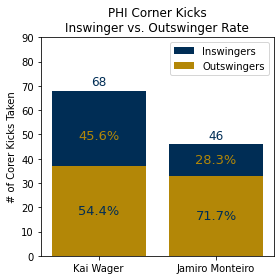

In [114]:
plt.figure(figsize=(4,4))

plt.bar(x=[1], height=[37+31], color='#002D55', label='Inswingers')
plt.bar(x=[1], height=[37], color='#B38707', label='Outswingers')
plt.text(x=1, y=37/2, s=f"{(37/(37+31))*100:.1f}%", color='#002D55', ha='center', va='center', fontsize=13)
plt.text(x=1, y=(31+31+37)/2, s=f"{(31/(37+31))*100:.1f}%", color='#B38707', ha='center', va='center', fontsize=13)
plt.text(x=1, y=37+31+1, s=f"{37+31}", color='#002D55', ha='center', va='bottom', fontsize=12)

plt.bar(x=[2], height=[33+13], color='#002D55')
plt.bar(x=[2], height=[33], color='#B38707')
plt.text(x=2, y=33/2, s=f"{(33/(33+13))*100:.1f}%", color='#002D55', ha='center', va='center', fontsize=13)
plt.text(x=2, y=(33+13+33)/2, s=f"{(13/(33+13))*100:.1f}%", color='#B38707', ha='center', va='center', fontsize=13)
plt.text(x=2, y=33+13+1, s=f"{33+13}", color='#002D55', ha='center', va='bottom', fontsize=12)

plt.xticks(ticks=[1,2], labels=['Kai Wager', 'Jamiro Monteiro'])
plt.ylabel('# of Corer Kicks Taken')

plt.title('PHI Corner Kicks\nInswinger vs. Outswinger Rate')

plt.ylim(0, 90)

plt.legend()

plt.tight_layout()
plt.savefig('PHI_Corner_Swing_Rate.png', dpi=200)

In [13]:
# I'll probably put what I found with Glesnes' G-xG above with the set piece section